In [21]:
# import os
# os.environ['JAX_PLATFORMS'] = ''

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.svm import SVR

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import MaxPooling1D
from keras.layers import Convolution1D

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

# 0. Tiền xử lý dữ liệu (Preprocessing)

### 0.0 Load dataset

In [2]:
data_train = "E:/IAD/INTERN/05_CMAPSS/CMAPSSData/train_FD003.txt"
rul_train = "E:/IAD/INTERN/05_CMAPSS/CMAPSSData/RUL_FD003.txt"
data_test = "E:/IAD/INTERN/05_CMAPSS/CMAPSSData/test_FD003.txt"

# define column names for easy indexing
index_names = ['engine_id', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((data_train), sep='\s+', header=None, names=col_names)
test = pd.read_csv((data_test), sep='\s+', header=None, names=col_names)
rul = pd.read_csv((rul_train), sep='\s+', header=None, names=['RUL'])

#shape and data
print(train.shape)
train.head()

(24720, 26)


,engine_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [3]:
# number of engines
print(f"The number of unit_nr:  {len(train['engine_id'].unique())}")
print(f"The number of RUL    :  {len(rul)}")

The number of unit_nr:  100
The number of RUL    :  100


### 0.1 Tính toán số chu kì còn lại trên bộ dữ liệu huấn luyên (train) - (FD_003)

In [4]:
#RUL for train_1 
rul_1 = pd.DataFrame(train.groupby('engine_id')['time_cycles'].max()).reset_index()
rul_1.columns = ['engine_id', 'max']

rul_train = train.merge(rul_1, on=['engine_id'], how='left')
rul_train['RUL'] = rul_train['max'] - rul_train['time_cycles']

rul_train.drop(['max'], axis=1, inplace=True)
rul_train.head()

,engine_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [5]:
rul_train.groupby('engine_id')['time_cycles'].describe().transpose()

engine_id,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
count,259.000000,253.000000,222.000000,272.000000,213.000000,278.000000,424.00000,267.000000,406.000000,481.000000,...,156.000000,158.000000,171.000000,392.000000,166.000000,491.000000,275.000000,307.000000,145.000000,152.000000
mean,130.000000,127.000000,111.500000,136.500000,107.000000,139.500000,212.50000,134.000000,203.500000,241.000000,...,78.500000,79.500000,86.000000,196.500000,83.500000,246.000000,138.000000,154.000000,73.000000,76.500000
std,74.911058,73.179004,64.230055,78.663842,61.631972,80.395895,122.54251,77.220464,117.346353,138.997002,...,45.177428,45.754781,49.507575,113.304898,48.064193,141.883755,79.529869,88.767487,42.001984,44.022721
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,65.500000,64.000000,56.250000,68.750000,54.000000,70.250000,106.75000,67.500000,102.250000,121.000000,...,39.750000,40.250000,43.500000,98.750000,42.250000,123.500000,69.500000,77.500000,37.000000,38.750000
50%,130.000000,127.000000,111.500000,136.500000,107.000000,139.500000,212.50000,134.000000,203.500000,241.000000,...,78.500000,79.500000,86.000000,196.500000,83.500000,246.000000,138.000000,154.000000,73.000000,76.500000
75%,194.500000,190.000000,166.750000,204.250000,160.000000,208.750000,318.25000,200.500000,304.750000,361.000000,...,117.250000,118.750000,128.500000,294.250000,124.750000,368.500000,206.500000,230.500000,109.000000,114.250000
max,259.000000,253.000000,222.000000,272.000000,213.000000,278.000000,424.00000,267.000000,406.000000,481.000000,...,156.000000,158.000000,171.000000,392.000000,166.000000,491.000000,275.000000,307.000000,145.000000,152.000000


In [6]:
rul_train.describe()

,engine_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.0,24720.00,24720.000000,24720.000000,24720.000000,2.472000e+04,...,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.0,24720.0,24720.000000,24720.000000,24720.000000
mean,48.631877,139.077063,-0.000024,0.000005,100.0,518.67,642.457858,1588.079175,1404.471212,1.462000e+01,...,2388.071643,8144.202916,8.396176,3.000000e-02,392.566545,2388.0,100.0,38.988552,23.393024,138.077063
std,29.348985,98.846675,0.002194,0.000294,0.0,0.00,0.523031,6.810418,9.773178,3.552786e-15,...,0.158121,16.504118,0.060512,1.734759e-17,1.761459,0.0,0.0,0.248865,0.149234,98.846675
min,1.000000,1.000000,-0.008600,-0.000600,100.0,518.67,640.840000,1564.300000,1377.060000,1.462000e+01,...,2386.930000,8099.680000,8.156300,3.000000e-02,388.000000,2388.0,100.0,38.170000,22.872600,0.000000
25%,23.000000,62.000000,-0.001500,-0.000200,100.0,518.67,642.080000,1583.280000,1397.187500,1.462000e+01,...,2388.010000,8134.510000,8.360600,3.000000e-02,391.000000,2388.0,100.0,38.830000,23.296200,61.000000
50%,47.000000,124.000000,-0.000000,-0.000000,100.0,518.67,642.400000,1587.520000,1402.910000,1.462000e+01,...,2388.070000,8141.200000,8.398300,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.391600,123.000000
75%,74.000000,191.000000,0.001500,0.000300,100.0,518.67,642.790000,1592.412500,1410.600000,1.462000e+01,...,2388.140000,8149.230000,8.437000,3.000000e-02,394.000000,2388.0,100.0,39.140000,23.483300,190.000000
max,100.000000,525.000000,0.008600,0.000700,100.0,518.67,645.110000,1615.390000,1441.160000,1.462000e+01,...,2388.610000,8290.550000,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500,524.000000


### 0.2 Tính toán số chu kì còn lại trên bộ dữ liệu kiểm thử (test) - (FD_003)

In [7]:
#RUL for test
rul["engine_id"]=rul.index + 1

max_1 = pd.DataFrame(test.groupby('engine_id')['time_cycles'].max()).reset_index()
max_1.columns = ['engine_id', 'max']
max_test = test.merge(max_1, on=['engine_id'], how='left')
rul_test = max_test.merge(rul, on=['engine_id'], how='left')

rul_test['RUL'] = rul_test['max'] - rul_test['time_cycles']
rul_test.drop(['max'], axis=1, inplace=True)

rul_test.head()

,engine_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,232
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,231
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,230
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,229
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,228


In [8]:
rul

,RUL,engine_id
0,44,1
1,51,2
2,27,3
3,120,4
4,101,5
...,...,...
95,113,96
96,123,97
97,17,98
98,8,99


### 0.3 Loại bỏ các cột chỉ số setting

In [9]:
#drop columns which has std=0 because they don't carry info about the state of the unit
deleted_1=["setting_1", "setting_2", "setting_3"]

rul_train.drop(columns=deleted_1, inplace=True)
rul_test.drop(columns=deleted_1, inplace=True)

print(rul_train.shape)
print(rul_test.shape)

(24720, 24)
(16596, 24)


### 0.4 Hiển thị chỉ số tương quan của các đặc trưng

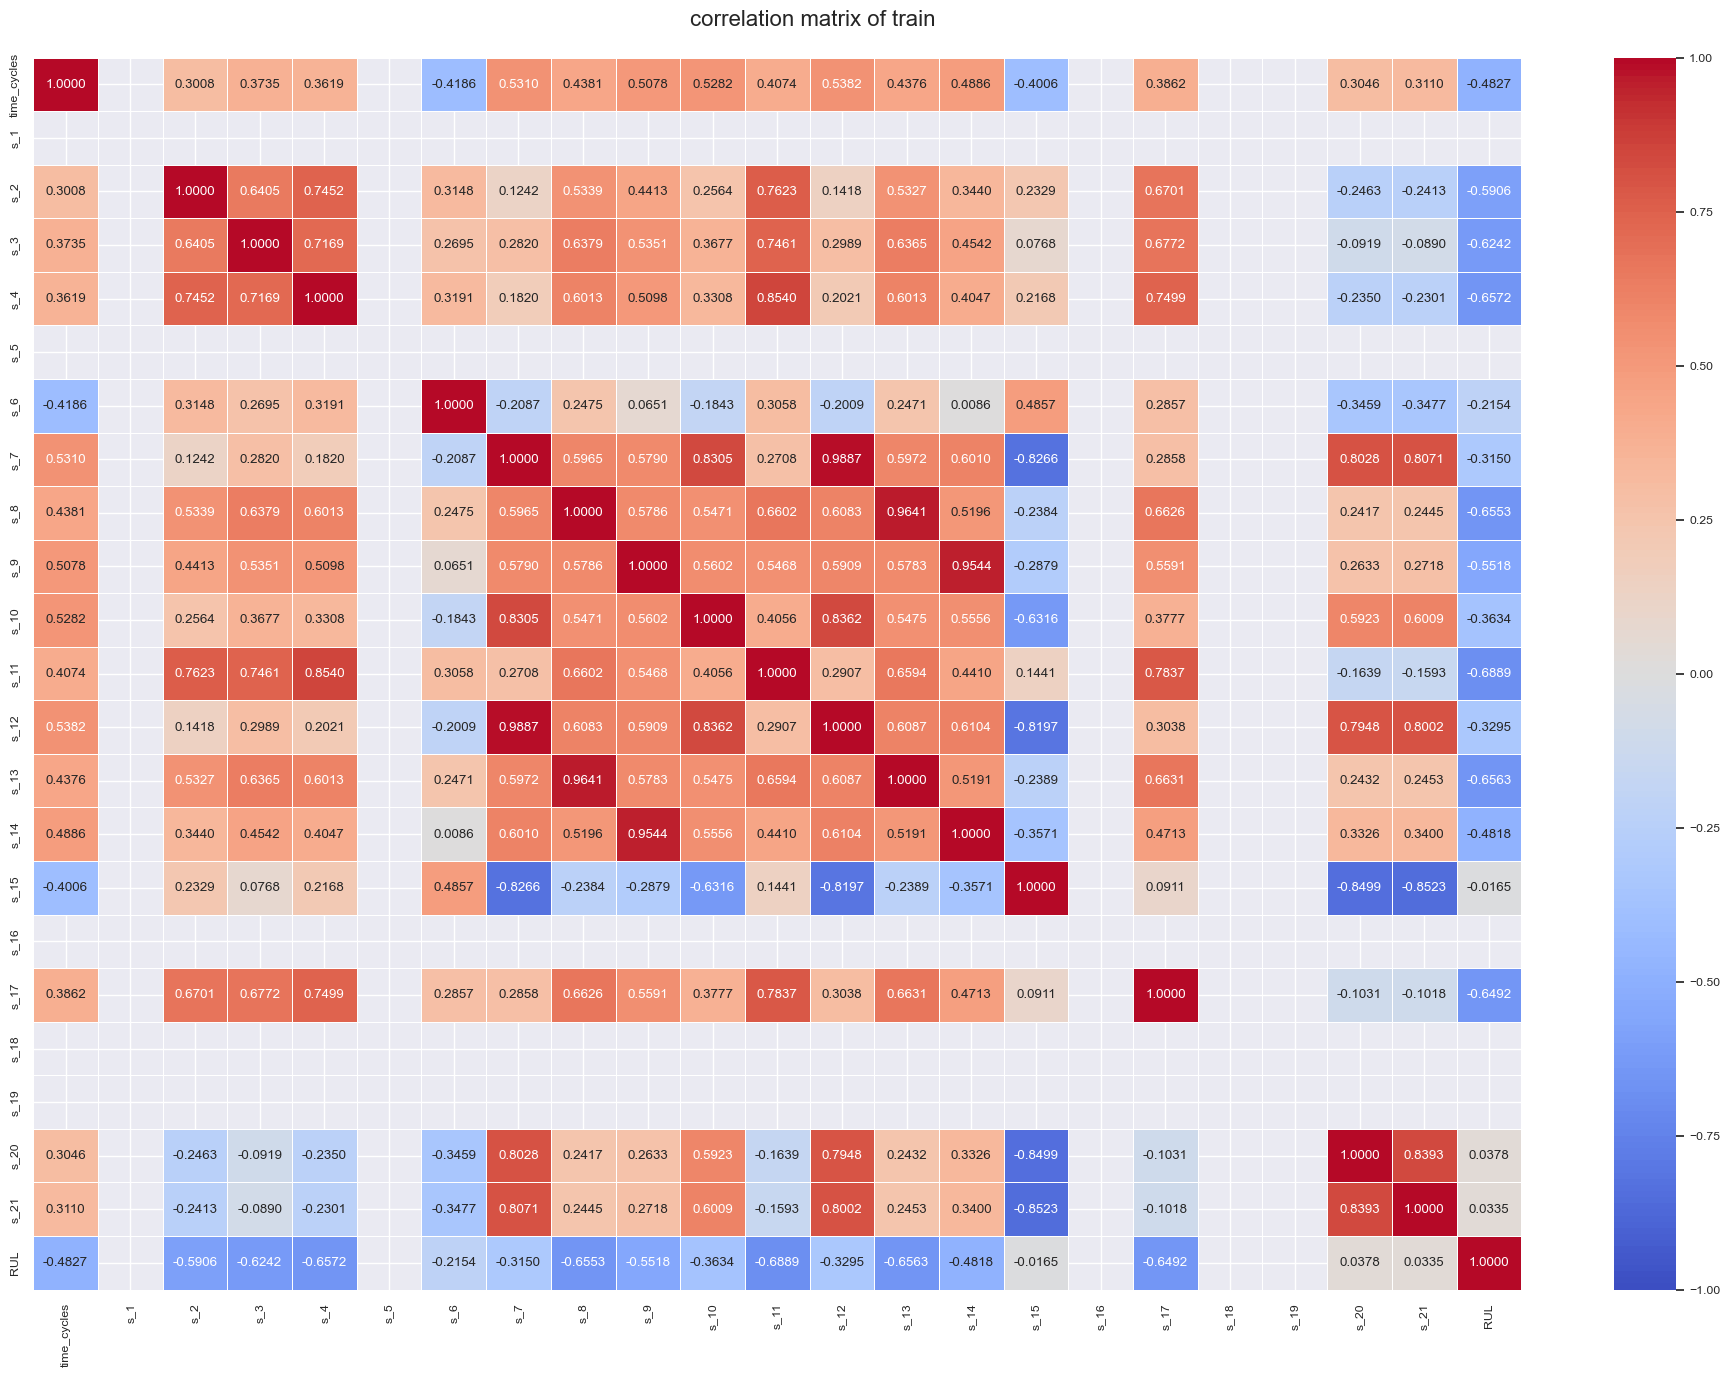

In [10]:
#heatmap for correlation coefficient

# calculate correlation
df_corr = rul_train.drop(columns=["engine_id"]).corr()

# correlation matrix
sns.set(font_scale=0.8)
plt.figure(figsize=(24,16))
sns.heatmap(df_corr, annot=True, fmt=".4f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.color_palette("coolwarm", 200))

plt.figtext(.45, 0.9,'correlation matrix of train', fontsize=16, ha='center')
plt.xticks(rotation=90)
plt.show()

### 0.5 Loại bỏ các chỉ số s1, s5, s16, s18, s19

***Giải thích:***
- dựa vào biểu đồ ma trận tương quan, các chỉ số của cảm biến ở s1, s5, s16, s18, s19 không có tương quan với nhãn đầu ra

=> ta có thể loại bỏ nó

In [11]:
corr_del=["s_1", "s_5", "s_16", "s_18", "s_19"]
rul_train.drop(columns=corr_del, inplace=True)
rul_test.drop(columns=corr_del, inplace=True)

print(rul_train.shape)
print(rul_test.shape)

(24720, 19)
(16596, 19)


### 0.6 feature selections and train_test_split on dataset

In [12]:
# x, y splitting
x_train = rul_train.drop(columns=["engine_id", "time_cycles", "RUL"])
x_test = rul_test.drop(columns=["engine_id", "time_cycles", "RUL"])
y_train = rul_train["RUL"]
y_test = rul_test["RUL"]

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(24720, 16)
(24720,)
(16596, 16)
(16596,)


# 1. Chuẩn hóa MinMaxScaler và sử dụng các mô hình học máy

### 1.1 Sử dụng MinMaxScaler để chuẩn hóa dữ liệu trước khi huấn luyện mô hình

In [17]:
# transform
feature_scaler = MinMaxScaler()
label_scaler = MinMaxScaler()

x_train_scaled = feature_scaler.fit_transform(x_train)
x_test_scaled = feature_scaler.fit_transform(x_test)

y_train_scaled = label_scaler.fit_transform(y_train.values.reshape(-1, 1)) 
y_test_scaled = label_scaler.fit_transform(y_test.values.reshape(-1, 1)) 

# inverser transform
# y_train_inverse = label_scaler.inverse_transform(y_train_scaled)
# y_test_inverse = label_scaler.inverse_transform(y_test_scaled)

# shuffle data
X_train, Y_train = shuffle(x_train_scaled, y_train_scaled, random_state=42)
X_test, Y_test = shuffle(x_test_scaled, y_test_scaled, random_state=42)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(24720, 16)
(24720, 1)
(16596, 16)
(16596, 1)


### 1.2 Mô hình Hồi quy tuyến tính - LinearRegression

In [25]:
# lưu kết quả dự đoán (có MinMaxScaler)
preds = []
pred_labels = []

In [26]:
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
pred = linear_model.predict(X_test)
preds.append(pred)
pred_labels.append('LinearRegression')

LinearRegression_MeanSquaredError = mean_squared_error(Y_test, pred)
LinearRegression_MeanAbsoluteError = mean_absolute_error(Y_test, pred)
LinearRegression_R2Score = r2_score(Y_test, pred)

print(f'MeanSquaredError = {LinearRegression_MeanSquaredError}')
print(f'MeanAbsoluteError = {LinearRegression_MeanAbsoluteError}')
print(f'R2Score = {LinearRegression_R2Score}')

MeanSquaredError = 0.026238399878448785
MeanAbsoluteError = 0.11973871266534888
R2Score = 0.15010200277826347


### 1.3 Mô hình Hồi quy Ridge và Lasso (Ridge and Lasso Regression)

In [28]:
# Mô hình Hồi quy Ridge
print("Các chỉ số mất mát Ridge model:")
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, Y_train)
pred = ridge_model.predict(X_test)
preds.append(pred)
pred_labels.append('Ridge')

Ridge_MeanSquaredError = mean_squared_error(Y_test, pred)
Ridge_MeanAbsoluteError = mean_absolute_error(Y_test, pred)
Ridge_R2Score = r2_score(Y_test, pred)

print(f'MeanSquaredError = {Ridge_MeanSquaredError}')
print(f'MeanAbsoluteError = {Ridge_MeanAbsoluteError}')
print(f'R2Score = {Ridge_R2Score}')


# Mô hình Hồi quy Lasso
print("\nCác chỉ số mất mát Lasso model:")
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, Y_train)
pred = lasso_model.predict(X_test)
preds.append(pred)
pred_labels.append('Lasso')

Lasso_MeanSquaredError = mean_squared_error(Y_test, pred)
Lasso_MeanAbsoluteError = mean_absolute_error(Y_test, pred)
Lasso_R2Score = r2_score(Y_test, pred)

print(f'MeanSquaredError = {Lasso_MeanSquaredError}')
print(f'MeanAbsoluteError = {Lasso_MeanAbsoluteError}')
print(f'R2Score = {Lasso_R2Score}')

Các chỉ số mất mát Ridge model:
MeanSquaredError = 0.02619269818820432
MeanAbsoluteError = 0.11966228710309718
R2Score = 0.1515823436217737

Các chỉ số mất mát Lasso model:
MeanSquaredError = 0.03263539219770598
MeanAbsoluteError = 0.14856574668762987
R2Score = -0.05710541023342319


### 1.4 Hồi quy đa thức (Polynomial Regression)

In [29]:
# Tạo mô hình Hồi quy đa thức với bậc 3
poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train_poly, Y_train)
pred = linear_model.predict(X_test_poly)
preds.append(pred)
pred_labels.append('Poly_Regression')

Poly_MeanSquaredError = mean_squared_error(Y_test, pred)
Poly_MeanAbsoluteError = mean_absolute_error(Y_test, pred)
Poly_R2Score = r2_score(Y_test, pred)

print(f'MeanSquaredError = {Poly_MeanSquaredError}')
print(f'MeanAbsoluteError = {Poly_MeanAbsoluteError}')
print(f'R2Score = {Poly_R2Score}')

MeanSquaredError = 0.12414728266619579
MeanAbsoluteError = 0.24927646484932275
R2Score = -3.0213018853022566


### 1.5 Rừng ngẫu nhiên (Random Forest)

In [30]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, Y_train)
pred = random_forest_model.predict(X_test)
preds.append(pred)
pred_labels.append('RandomForestRegressor')

RandomForestRegressor_MeanSquaredError = mean_squared_error(Y_test, pred)
RandomForestRegressor_MeanAbsoluteError = mean_absolute_error(Y_test, pred)
RandomForestRegressor_R2Score = r2_score(Y_test, pred)

print(f'MeanSquaredError = {RandomForestRegressor_MeanSquaredError}')
print(f'MeanAbsoluteError = {RandomForestRegressor_MeanAbsoluteError}')
print(f'R2Score = {RandomForestRegressor_R2Score}')

e:\IAD\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MeanSquaredError = 0.02919703412692676
MeanAbsoluteError = 0.11928827787263159
R2Score = 0.05426775473181866


### 1.6 Gradient Boosting Machines (GBM)

In [34]:
GradientBoostingRegressor_model = GradientBoostingRegressor()
GradientBoostingRegressor_model.fit(X_train, Y_train)
pred = GradientBoostingRegressor_model.predict(X_test)
preds.append(pred)
pred_labels.append('GradientBoostingRegressor')

GradientBoostingRegressor_MeanSquaredError = mean_squared_error(Y_test, pred)
GradientBoostingRegressor_MeanAbsoluteError = mean_absolute_error(Y_test, pred)
GradientBoostingRegressor_R2Score = r2_score(Y_test, pred)

print(f'MeanSquaredError = {GradientBoostingRegressor_MeanSquaredError}')
print(f'MeanAbsoluteError = {GradientBoostingRegressor_MeanAbsoluteError}')
print(f'R2Score = {GradientBoostingRegressor_R2Score}')

MeanSquaredError = 0.032978856498294545
MeanAbsoluteError = 0.1258285703389346
R2Score = -0.06823069312184904


### 1.7 Hồi quy hỗ trợ vectơ (Support Vector Regression - SVR)

In [35]:
SVR_model = SVR()
SVR_model.fit(X_train, Y_train)
pred = SVR_model.predict(X_test)
preds.append(pred)
pred_labels.append('SVR')

SVR_MeanSquaredError = mean_squared_error(Y_test, pred)
SVR_MeanAbsoluteError = mean_absolute_error(Y_test, pred)
SVR_R2Score = r2_score(Y_test, pred)

print(f'MeanSquaredError = {SVR_MeanSquaredError}')
print(f'MeanAbsoluteError = {SVR_MeanAbsoluteError}')
print(f'R2Score = {SVR_R2Score}')

MeanSquaredError = 0.040408782844367226
MeanAbsoluteError = 0.1435440915698208
R2Score = -0.3088962653474945


### 1.8 So sánh hiệu suất các mô hình có áp dụng kĩ thuật MinMaxScaler

In [38]:
mean_squared_errors = [
    LinearRegression_MeanSquaredError,
    Ridge_MeanSquaredError,
    Lasso_MeanSquaredError,
    Poly_MeanSquaredError,
    RandomForestRegressor_MeanSquaredError,
    GradientBoostingRegressor_MeanSquaredError,
    SVR_MeanSquaredError,
]
label_mean_square_errors = [
    "LinearRegression_MeanSquaredError",
    "Ridge_MeanSquaredError",
    "Lasso_MeanSquaredError",
    "Poly_MeanSquaredError",
    "RandomForestRegressor_MeanSquaredError",
    "GradientBoostingRegressor_MeanSquaredError",
    "SVR_MeanSquaredError"
]

mean_absolute_errors = [
    LinearRegression_MeanAbsoluteError,
    Ridge_MeanAbsoluteError,
    Lasso_MeanAbsoluteError,
    Poly_MeanAbsoluteError,
    RandomForestRegressor_MeanAbsoluteError,
    GradientBoostingRegressor_MeanAbsoluteError,
    SVR_MeanAbsoluteError,
]
label_mean_absolute_errors = [
    "LinearRegression_MeanAbsoluteError",
    "Ridge_MeanAbsoluteError",
    "Lasso_MeanAbsoluteError",
    "Poly_MeanAbsoluteError",
    "RandomForestRegressor_MeanSquaredError",
    "GradientBoostingRegressor_MeanAbsoluteError",
    "SVR_MeanAbsoluteError"
]

r2_scores = [
    LinearRegression_R2Score,
    Ridge_R2Score,
    Lasso_R2Score,
    Poly_R2Score,
    RandomForestRegressor_R2Score,
    GradientBoostingRegressor_R2Score,
    SVR_R2Score,
]
label_r2_scores = [
    "LinearRegression_R2Score",
    "Ridge_R2Score",
    "Lasso_R2Score",
    "Poly_R2Score",
    "RandomForestRegressor_R2Score",
    "GradientBoostingRegressor_R2Score",
    "SVR_R2Score"
]

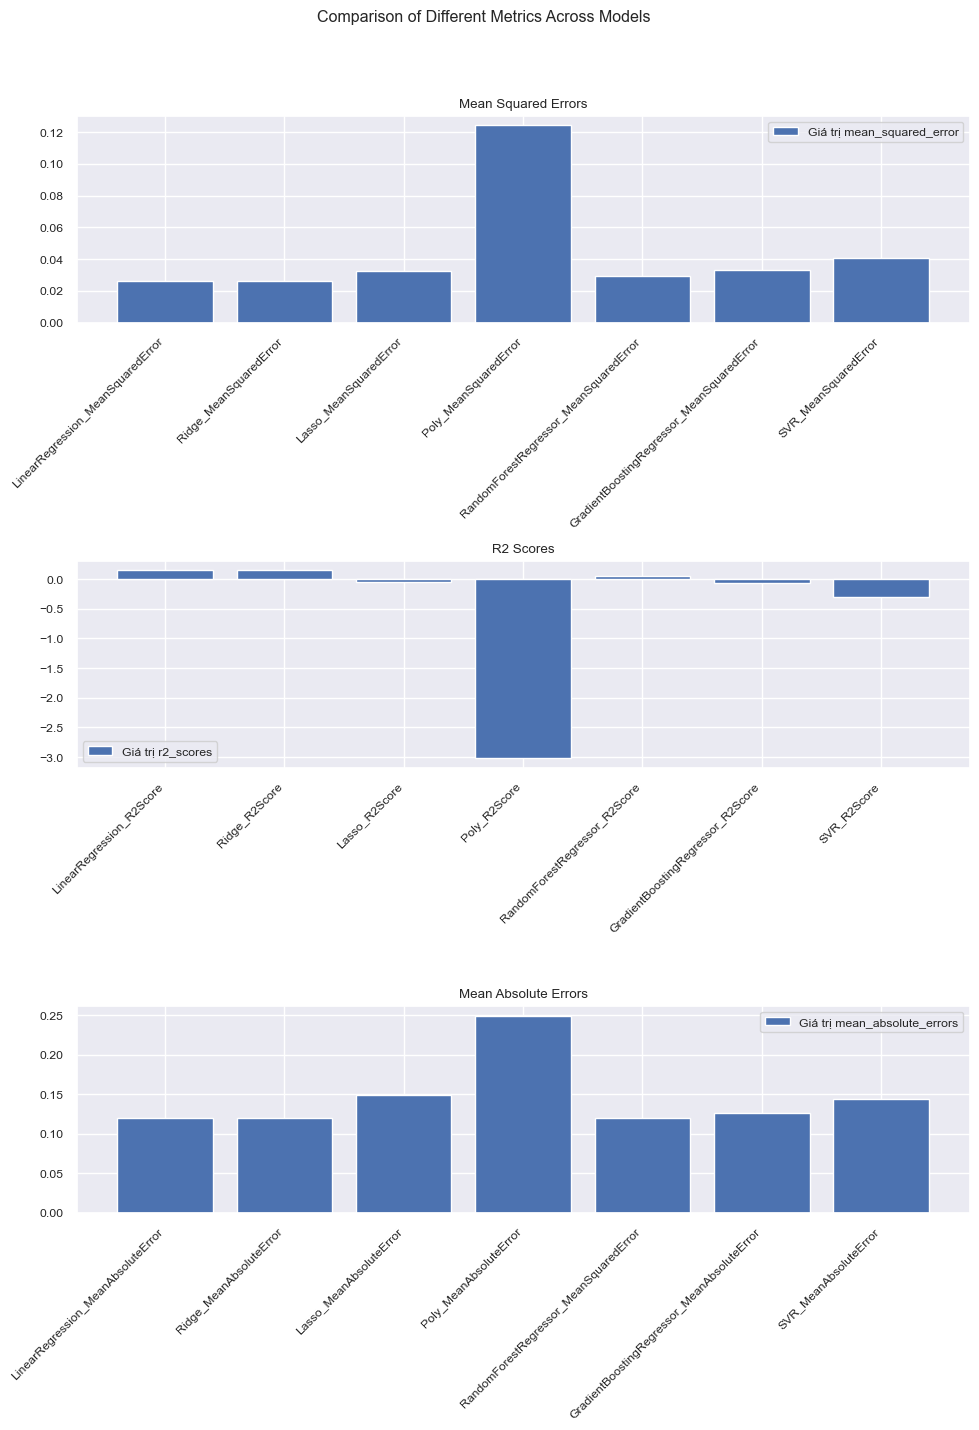

In [39]:
# Tạo hình và các subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Biểu đồ 1: mean_squared_errors
axs[0].bar(label_mean_square_errors, mean_squared_errors, label='Giá trị mean_squared_error')
axs[0].set_title('Mean Squared Errors')
axs[0].legend()
axs[0].set_xticks(label_mean_square_errors)
axs[0].set_xticklabels(label_mean_square_errors, rotation=45, ha='right')
axs[0].grid(True)

# Biểu đồ 2: r2_scores
axs[1].bar(label_r2_scores, r2_scores, label='Giá trị r2_scores')
axs[1].set_title('R2 Scores')
axs[1].legend()
axs[1].set_xticks(label_r2_scores)
axs[1].set_xticklabels(label_r2_scores, rotation=45, ha='right')
axs[1].grid(True)

# Biểu đồ 3: mean_absolute_errors
axs[2].bar(label_mean_absolute_errors, mean_absolute_errors, label='Giá trị mean_absolute_errors')
axs[2].set_title('Mean Absolute Errors')
axs[2].legend()
axs[2].set_xticks(label_mean_absolute_errors)
axs[2].set_xticklabels(label_mean_absolute_errors, rotation=45, ha='right')
axs[2].grid(True)

# Thêm tiêu đề cho toàn bộ hình
fig.suptitle('Comparison of Different Metrics Across Models')

# Hiển thị biểu đồ
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 1.9 Đối chiếu kết quả thực tế và kết quả dự đoán

In [226]:
# ý tưởng:
# từ kết quả dự đoán sẽ phải chuyển đổi (inverser transform) như ban đầu để có cái nhìn trực quan hơn


# 2. Sử dụng các mô hình học máy không chuẩn hóa MinMaxScaler

In [40]:
# Lưu kết quả dự đoán
preds = []
pred_labels = []

### 2.1 Sử dụng mô hình Hồi quy tuyến tính - LinearRegression

In [41]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
pred = linear_model.predict(x_test)
preds.append(pred)
pred_labels.append('LinearRegression')

LinearRegression_MeanSquaredError = mean_squared_error(y_test, pred)
LinearRegression_MeanAbsoluteError = mean_absolute_error(y_test, pred)
LinearRegression_R2Score = r2_score(y_test, pred)

print(f'MeanSquaredError = {LinearRegression_MeanSquaredError}')
print(f'MeanAbsoluteError = {LinearRegression_MeanAbsoluteError}')
print(f'R2Score = {LinearRegression_R2Score}')

MeanSquaredError = 10058.964262510097
MeanAbsoluteError = 84.79038015580979
R2Score = -0.45019379030815787


### 2.2 Rừng ngẫu nhiên (Random Forest)

In [42]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train, y_train)
pred = random_forest_model.predict(x_test)
preds.append(pred)
pred_labels.append('RandomForestRegressor')

RandomForestRegressor_MeanSquaredError = mean_squared_error(y_test, pred)
RandomForestRegressor_MeanAbsoluteError = mean_absolute_error(y_test, pred)
RandomForestRegressor_R2Score = r2_score(y_test, pred)

print(f'MeanSquaredError = {RandomForestRegressor_MeanSquaredError}')
print(f'MeanAbsoluteError = {RandomForestRegressor_MeanAbsoluteError}')
print(f'R2Score = {RandomForestRegressor_R2Score}')

MeanSquaredError = 10978.428204880694
MeanAbsoluteError = 86.57018679199808
R2Score = -0.5827522590371603


### 2.3 Gradient Boosting Machines (GBM)

In [43]:
GradientBoostingRegressor_model = GradientBoostingRegressor()
GradientBoostingRegressor_model.fit(x_train, y_train)
pred = GradientBoostingRegressor_model.predict(X_test)
preds.append(pred)
pred_labels.append('GradientBoostingRegressor')

GradientBoostingRegressor_MeanSquaredError = mean_squared_error(y_test, pred)
GradientBoostingRegressor_MeanAbsoluteError = mean_absolute_error(y_test, pred)
GradientBoostingRegressor_R2Score = r2_score(y_test, pred)

print(f'MeanSquaredError = {GradientBoostingRegressor_MeanSquaredError}')
print(f'MeanAbsoluteError = {GradientBoostingRegressor_MeanAbsoluteError}')
print(f'R2Score = {GradientBoostingRegressor_R2Score}')

MeanSquaredError = 15972.57386755664
MeanAbsoluteError = 113.1145769494874
R2Score = -1.302754720413815


### 2.4 Hồi quy hỗ trợ vectơ (Support Vector Regression - SVR)

In [44]:
SVR_model = SVR()
SVR_model.fit(x_train, y_train)
pred = SVR_model.predict(x_test)
preds.append(pred)
pred_labels.append('SVR')

SVR_MeanSquaredError = mean_squared_error(y_test, pred)
SVR_MeanAbsoluteError = mean_absolute_error(y_test, pred)
SVR_R2Score = r2_score(y_test, pred)

print(f'MeanSquaredError = {SVR_MeanSquaredError}')
print(f'MeanAbsoluteError = {SVR_MeanAbsoluteError}')
print(f'R2Score = {SVR_R2Score}')

MeanSquaredError = 7257.325018286501
MeanAbsoluteError = 69.77537843866911
R2Score = -0.0462834344677201


### 2.5 Vẽ biểu đồ so sánh mất mát của các mô hình (không sử dụng MinMaxScaler)

In [45]:
mean_squared_errors = [
    LinearRegression_MeanSquaredError,
    RandomForestRegressor_MeanSquaredError,
    GradientBoostingRegressor_MeanSquaredError,
    SVR_MeanSquaredError,
]
label_mean_square_errors = [
    "LinearRegression_MeanSquaredError",
    "RandomForestRegressor_MeanSquaredError",
    "GradientBoostingRegressor_MeanSquaredError",
    "SVR_MeanSquaredError"
]

mean_absolute_errors = [
    LinearRegression_MeanAbsoluteError,
    RandomForestRegressor_MeanAbsoluteError,
    GradientBoostingRegressor_MeanAbsoluteError,
    SVR_MeanAbsoluteError,
]
label_mean_absolute_errors = [
    "LinearRegression_MeanAbsoluteError",
    "RandomForestRegressor_MeanSquaredError",
    "RandomForestRegressor_MeanAbsoluteError",
    "SVR_MeanAbsoluteError"
]

r2_scores = [
    LinearRegression_R2Score,
    RandomForestRegressor_R2Score,
    GradientBoostingRegressor_R2Score,
    SVR_R2Score,
]
label_r2_scores = [
    "LinearRegression_R2Score",
    "RandomForestRegressor_R2Score",
    "GradientBoostingRegressor_R2Score",
    "SVR_R2Score"
]

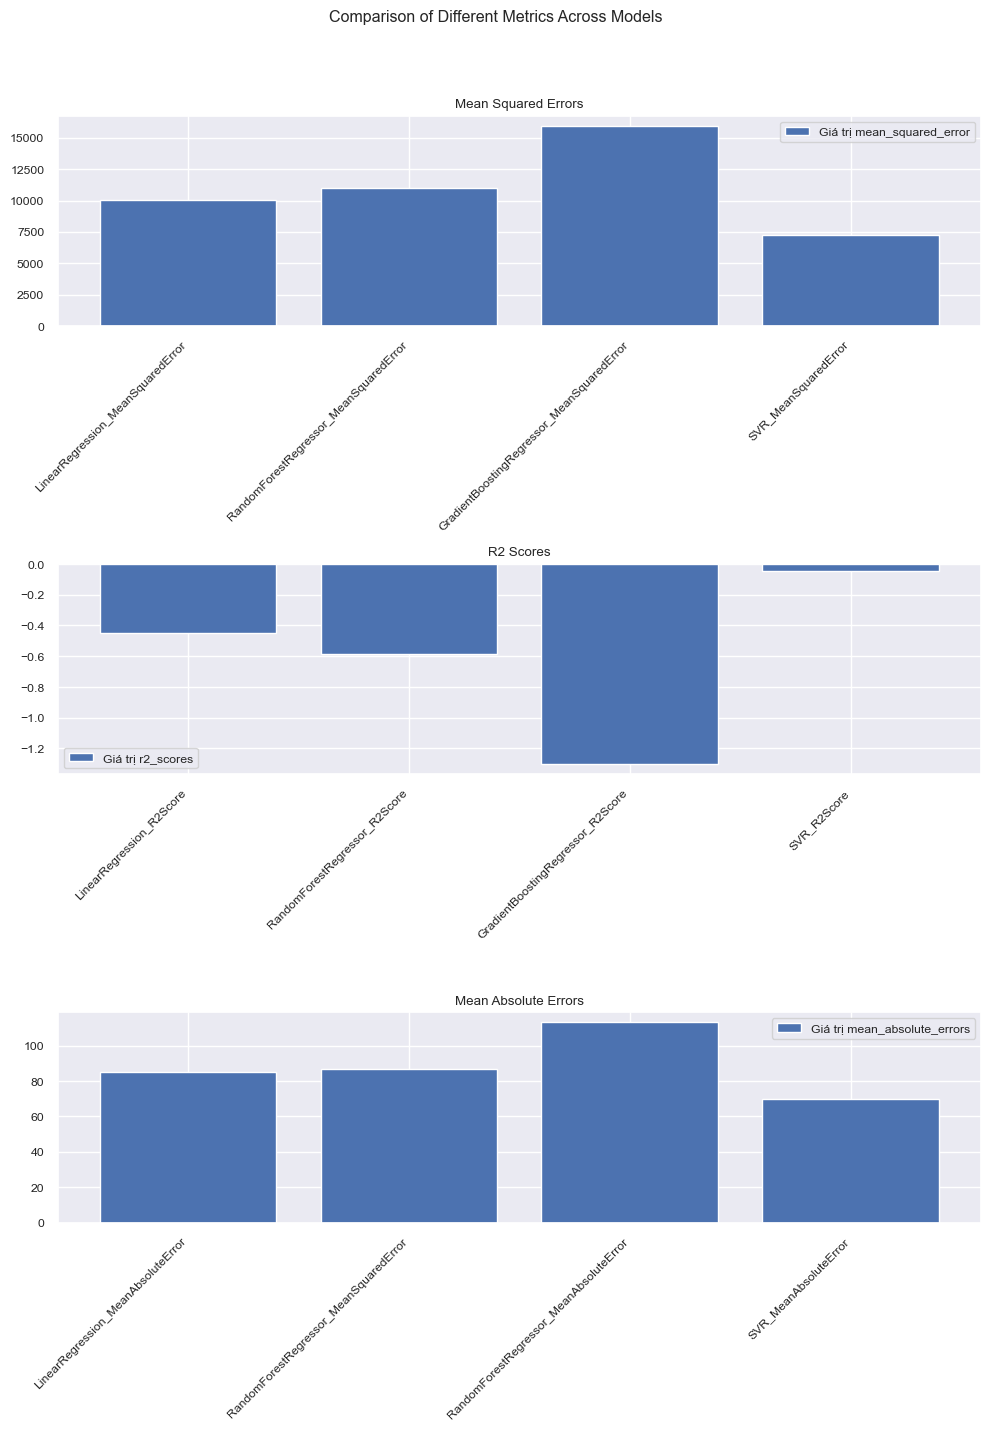

In [46]:
# Tạo hình và các subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Biểu đồ 1: mean_squared_errors
axs[0].bar(label_mean_square_errors, mean_squared_errors, label='Giá trị mean_squared_error')
axs[0].set_title('Mean Squared Errors')
axs[0].legend()
axs[0].set_xticks(label_mean_square_errors)
axs[0].set_xticklabels(label_mean_square_errors, rotation=45, ha='right')
axs[0].grid(True)

# Biểu đồ 2: r2_scores
axs[1].bar(label_r2_scores, r2_scores, label='Giá trị r2_scores')
axs[1].set_title('R2 Scores')
axs[1].legend()
axs[1].set_xticks(label_r2_scores)
axs[1].set_xticklabels(label_r2_scores, rotation=45, ha='right')
axs[1].grid(True)

# Biểu đồ 3: mean_absolute_errors
axs[2].bar(label_mean_absolute_errors, mean_absolute_errors, label='Giá trị mean_absolute_errors')
axs[2].set_title('Mean Absolute Errors')
axs[2].legend()
axs[2].set_xticks(label_mean_absolute_errors)
axs[2].set_xticklabels(label_mean_absolute_errors, rotation=45, ha='right')
axs[2].grid(True)

# Thêm tiêu đề cho toàn bộ hình
fig.suptitle('Comparison of Different Metrics Across Models')

# Hiển thị biểu đồ
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2.6 Vẽ biểu đồ đối chiếu kết quả thực tế và kết quả dự đoán

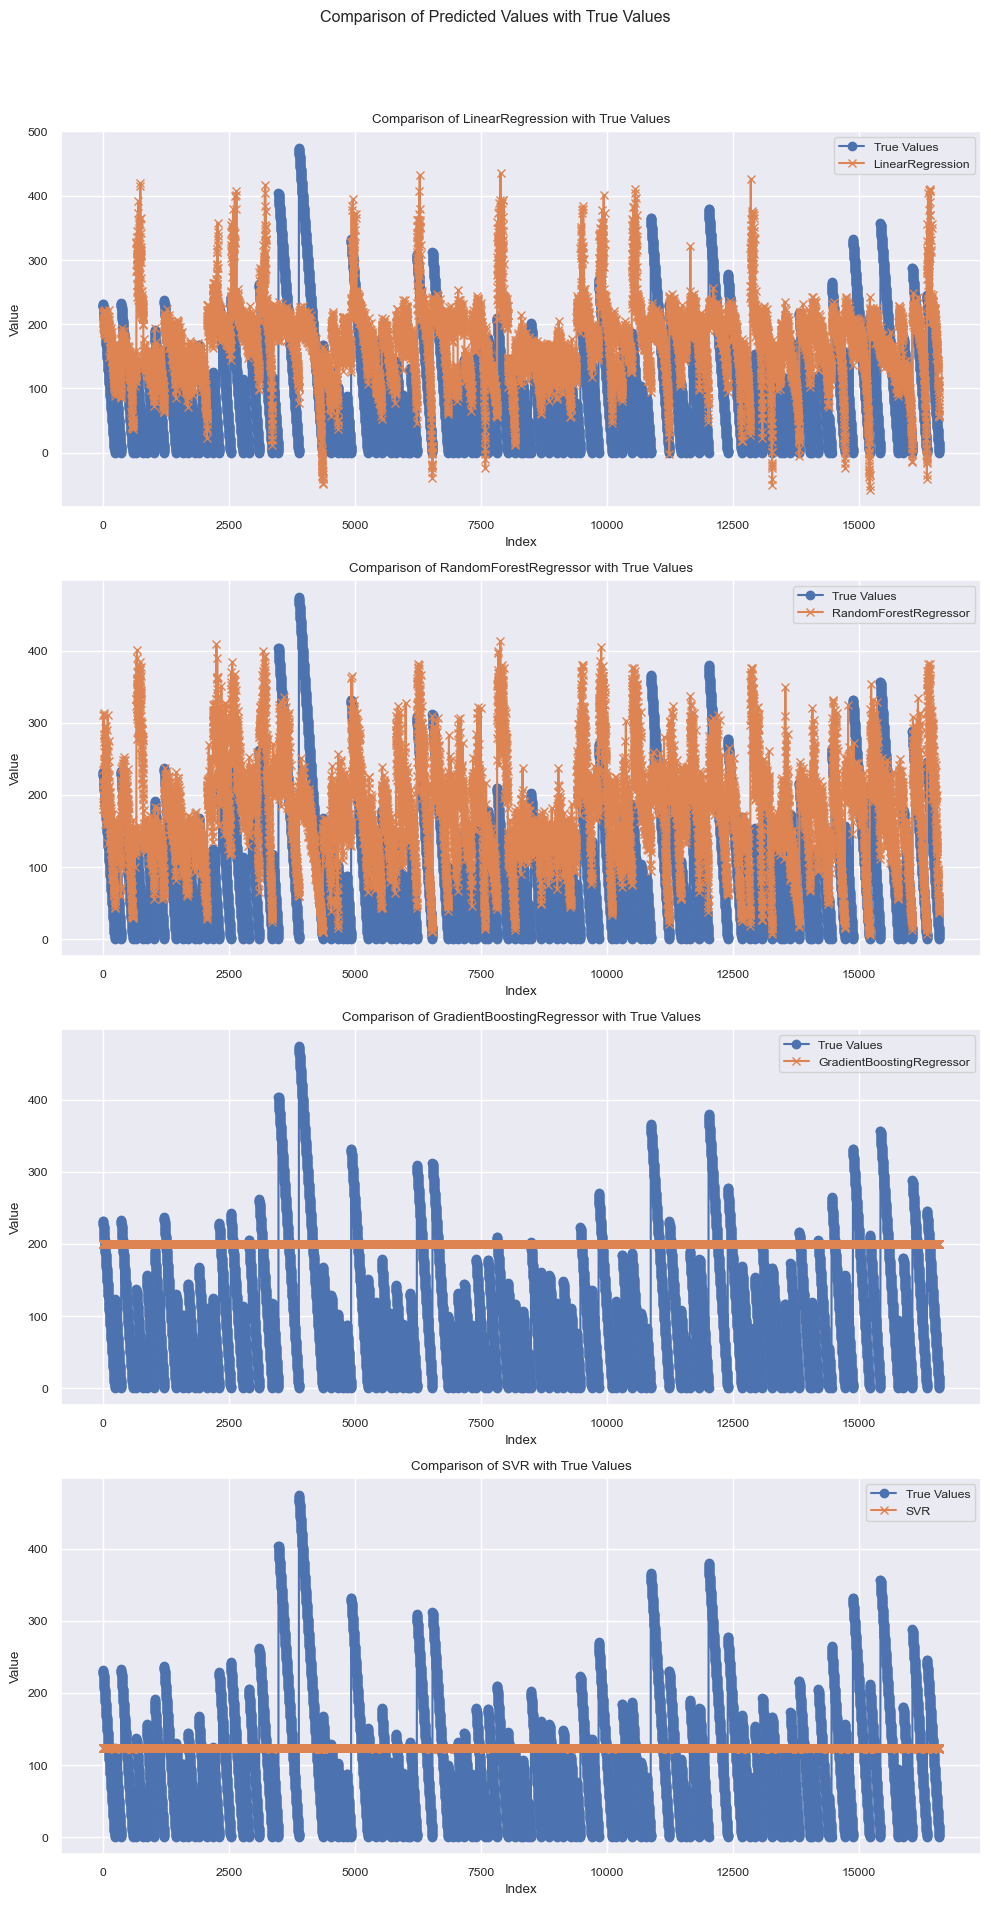

In [47]:
# Tạo hình và các subplots
fig, axs = plt.subplots(len(preds), 1, figsize=(10, 5 * len(preds)))

# Nếu chỉ có một mô hình dự đoán, axs sẽ không phải là một mảng, vì vậy chúng ta cần đảm bảo nó luôn là một mảng
if len(preds) == 1:
    axs = [axs]

# Vẽ biểu đồ đường cho từng mảng trong preds và so sánh với y_test
for i in range(len(preds)):
    axs[i].plot(y_test, label='True Values', marker='o')
    axs[i].plot(preds[i], label=pred_labels[i], marker='x')
    axs[i].set_title(f'Comparison of {pred_labels[i]} with True Values')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()
    axs[i].grid(True)

# Thêm tiêu đề cho toàn bộ hình
fig.suptitle('Comparison of Predicted Values with True Values')

# Hiển thị biểu đồ
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. Sử dụng mạng neural network để huấn luyện mô hình

### 3.1 Sử dụng mô hình mạng thần kinh nhân tạo (Artificial Neural Network)

In [255]:
# print(train.head())
# print(test.head())
# print(rul.head())

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(24720, 16)
(24720,)
(16596, 16)
(16596,)


In [256]:
x_train.head()

,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,642.36,1583.23,1396.84,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537
1,642.50,1584.69,1396.89,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491
2,642.18,1582.35,1405.61,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669
3,642.92,1585.61,1392.27,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951
4,641.68,1588.63,1397.65,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583


In [291]:
x_train_1 = x_train.copy()
y_train_1 = y_train.copy()

x_test_1 = x_test.copy()
y_test_1 = y_test.copy()

In [292]:
# Normalize features
scaler = StandardScaler()
x_train_1 = scaler.fit_transform(x_train_1)
x_test_1 = scaler.fit_transform(x_test_1)

x_train_1 = np.array(x_train_1)
x_test_1 = np.array(x_test_1)
y_train_1 = np.array(y_train_1)
y_test_1 = np.array(y_test_1)

print(x_train_1.shape)
print(y_train_1.shape)
print(x_test_1.shape)
print(y_test_1.shape)

(24720, 16)
(24720,)
(16596, 16)
(16596,)


### Artificial Neural Network (ANN v1)

In [294]:
model_1 = Sequential()
model_1.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.15))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(optimizer='Adam', loss='mean_squared_error')
model_1.fit(x_train_1, y_train_1, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 15261.7031 - val_loss: 5172.6636
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - loss: 3693.1719 - val_loss: 5454.2207
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - loss: 3626.0305 - val_loss: 5143.5508
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3568.0479 - val_loss: 4944.5459
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - loss: 3602.4226 - val_loss: 5103.5151
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 3515.0066 - val_loss: 4840.0884
Epoch 7/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 3480.8289 - val_loss: 5528.7363
Epoch 8/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 3640.0696 - val_loss: 5037.0708
Epoch 9/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 3429.0527 - val_loss: 4694.0493
Epoch 10/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 3427.3792 - val_loss: 5192.1714
Epoch 11/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/s

### Artificial Neural Network (ANN v2)

In [295]:
model_1 = Sequential()
model_1.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.15))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(optimizer='Adam', loss='mean_squared_error')
model_1.fit(x_train_1, y_train_1, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12619.9111 - val_loss: 5927.3262
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3896.6396 - val_loss: 5282.1992
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 3655.6179 - val_loss: 4651.8354
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - loss: 3638.0444 - val_loss: 5732.6924
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3544.0281 - val_loss: 5107.2856
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3397.0803 - val_loss: 4435.6284
Epoch 7/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3587.2744 - val_loss: 4858.5229
Epoch 8/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3514.5994 - val_loss: 5113.3760
Epoch 9/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3481.6404 - val_loss: 4948.5151
Epoch 10/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3379.4341 - val_loss: 5210.0288
Epoch 11/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 33

### 3.2 Sử dụng mô hình LSTM

In [14]:
rul_train.head()
train_1 = rul_train.copy()
test_1 = rul_test.copy()
rul_1 = rul_train['RUL']
train_1.head()

,engine_id,time_cycles,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,642.36,1583.23,1396.84,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,258
1,1,2,642.50,1584.69,1396.89,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,257
2,1,3,642.18,1582.35,1405.61,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,256
3,1,4,642.92,1585.61,1392.27,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,255
4,1,5,641.68,1588.63,1397.65,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,254


In [15]:
# train_1 minmax scaling
cols_normalize = train_1.columns.difference(['engine_id','cycle'])

scaler_1 = MinMaxScaler()
norm_train = pd.DataFrame(scaler_1.fit_transform(train_1[cols_normalize]), 
                                columns=cols_normalize, 
                                index=train_1.index)

norm_train_1=pd.concat([norm_train, train_1[["engine_id", "time_cycles"]]], axis=1)


#test_1 minmax scaling
norm_test_1 = pd.DataFrame(scaler_1.transform(rul_test[cols_normalize]), 
                                columns=cols_normalize, 
                                index=rul_test.index)

norm_test_1=pd.concat([norm_test_1, rul_test[["engine_id", "time_cycles"]]], axis=1)

In [16]:
norm_train_1.head()

,RUL,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_2,s_20,s_21,s_3,s_4,s_6,s_7,s_8,s_9,time_cycles,engine_id,time_cycles
0,0.492366,0.333333,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.355972,0.559524,0.446331,0.370523,0.308580,1.0,0.208812,0.623529,0.204233,0.000000,1,1
1,0.490458,0.333333,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.388759,0.488095,0.534836,0.399100,0.309360,1.0,0.236590,0.647059,0.202431,0.001908,1,2
2,0.488550,0.333333,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.313817,0.404762,0.458577,0.353298,0.445398,1.0,0.230843,0.664706,0.241484,0.003817,1,3
3,0.486641,0.333333,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.487119,0.470238,0.391966,0.417107,0.237285,1.0,0.268199,0.647059,0.215326,0.005725,1,4
4,0.484733,0.333333,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.196721,0.577381,0.543371,0.476218,0.321217,1.0,0.245690,0.670588,0.268799,0.007634,1,5


In [17]:
#split engines for set_1
g_1 = norm_train_1.groupby('engine_id')
g_test1 = norm_test_1.groupby('engine_id')

#list of dfs(engines)
train_list = []
test_list = []  

for engineid in g_1.groups.keys():
    train_list.append(g_1.get_group(engineid)) 

for engineid in g_test1.groups.keys():
    test_list.append(g_test1.get_group(engineid))

In [18]:
print(len(train_list))
print(len(test_list))

100
100


In [19]:
#generating sequences for each engine --> multivariate one step problem
from numpy import array

#df: df extracted from train_list, n_steps: window size
def split_sequences(df, n_steps):
    X, y = list(), list()
    for i in range(len(df)):
        end_ix = i + n_steps
        if end_ix > len(df):
            break
        seq_x, seq_y = df[i:end_ix, 1:], df[end_ix-1, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


list_x = []
list_y = []
for engine_df in train_list:
    #convert df to arr 
    engine_arr = engine_df.drop(columns=["engine_id", "time_cycles"]).to_numpy()
    X, y = split_sequences(engine_arr, 21) # since smallest df has 21 rows
    list_x.append(X)
    list_y.append(y)

#concat alt alta  
X_arr=np.concatenate(list_x)
y_arr=np.concatenate(list_y)

### CNN+LSTM v1

In [22]:
seq_len = X_arr.shape[1]
num_features = X_arr.shape[2]
input_shape = (seq_len, num_features)

model = Sequential()
# ------------------------------

model.add(Convolution1D(input_shape=input_shape, filters=18, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Convolution1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Convolution1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dense(input_shape[0]*input_shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(input_shape[1]*3, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(input_shape[1]*3))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse')
# model.fit(x_train, y_train, epochs=10, batch_size=200)
# ------------------------------

# model.add(LSTM(input_shape=(seq_len, num_features), units=100, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=10, return_sequences=False))
# model.add(Dropout(0.2))

# model.add(Dense(units=1))
# model.compile(optimizer='adam', loss='mse')

# #This callback will stop the training when there is no improvement in the validation loss for 20 consecutive epochs. 
# #regularization technique as preventing overfitting, model runtime gets shorter
# callback = EarlyStopping(monitor='loss', patience=20)

# fit model
history=model.fit(X_arr, y_arr, epochs=20)
history = history.history['loss']

Epoch 1/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0214
Epoch 2/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0127
Epoch 3/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0123
Epoch 4/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0118
Epoch 5/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0114
Epoch 6/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0115
Epoch 7/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0113
Epoch 8/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0109
Epoch 9/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0109
Epoch 10/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0107
Epoch 11/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0104
Epoch 12/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0103
Epoch 13/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0105
Epoch 14/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0103
Epoch 15/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - lo

### CNN+LSTM v2

In [31]:
# train_1 minmax scaling
# cols_normalize = train_1.columns.difference(['engine_id','cycle'])

# scaler_1 = MinMaxScaler()
# norm_train = pd.DataFrame(scaler_1.fit_transform(train_1[cols_normalize]), 
#                                 columns=cols_normalize, 
#                                 index=train_1.index)
norm_train_1 = train_1

# norm_train_1=pd.concat([norm_train, train_1[["engine_id", "time_cycles"]]], axis=1)


#test_1 minmax scaling
# norm_test_1 = pd.DataFrame(scaler_1.transform(rul_test[cols_normalize]), 
#                                 columns=cols_normalize, 
#                                 index=rul_test.index)

# norm_test_1=pd.concat([norm_test_1, rul_test[["engine_id", "time_cycles"]]], axis=1)
norm_test_1 = rul_test

In [32]:
#split engines for set_1
g_1 = norm_train_1.groupby('engine_id')
g_test1 = norm_test_1.groupby('engine_id')

#list of dfs(engines)
train_list = []
test_list = []  

for engineid in g_1.groups.keys():
    train_list.append(g_1.get_group(engineid)) 

for engineid in g_test1.groups.keys():
    test_list.append(g_test1.get_group(engineid))

In [33]:
#generating sequences for each engine --> multivariate one step problem
from numpy import array

#df: df extracted from train_list, n_steps: window size
def split_sequences(df, n_steps):
    X, y = list(), list()
    for i in range(len(df)):
        end_ix = i + n_steps
        if end_ix > len(df):
            break
        seq_x, seq_y = df[i:end_ix, 1:], df[end_ix-1, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


list_x = []
list_y = []
for engine_df in train_list:
    #convert df to arr 
    engine_arr = engine_df.drop(columns=["engine_id", "time_cycles"]).to_numpy()
    X, y = split_sequences(engine_arr, 21) # since smallest df has 21 rows
    list_x.append(X)
    list_y.append(y)

#concat alt alta  
X_arr=np.concatenate(list_x)
y_arr=np.concatenate(list_y)

In [37]:
seq_len = X_arr.shape[1]
num_features = X_arr.shape[2]
input_shape = (seq_len, num_features)

model = Sequential()
# ------------------------------

model.add(Convolution1D(input_shape=input_shape, filters=18, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Convolution1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Convolution1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dense(input_shape[0]*input_shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(input_shape[1]*3, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(input_shape[1]*3))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mean_absolute_error')
# model.fit(x_train, y_train, epochs=10, batch_size=200)
# ------------------------------

# model.add(LSTM(input_shape=(seq_len, num_features), units=100, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=10, return_sequences=False))
# model.add(Dropout(0.2))

# model.add(Dense(units=1))
# model.compile(optimizer='adam', loss='mse')

# #This callback will stop the training when there is no improvement in the validation loss for 20 consecutive epochs. 
# #regularization technique as preventing overfitting, model runtime gets shorter
# callback = EarlyStopping(monitor='loss', patience=20)

# fit model
history=model.fit(X_arr, y_arr, epochs=50)
history = history.history['loss']

Epoch 1/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 473.1015
Epoch 2/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 56.3802
Epoch 3/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 56.1436
Epoch 4/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 56.3650
Epoch 5/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 56.3409
Epoch 6/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 56.5061
Epoch 7/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 55.3000
Epoch 8/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 55.1918
Epoch 9/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 55.6896
Epoch 10/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 54.4888
Epoch 11/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 55.0811
Epoch 12/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 55.4040
Epoch 13/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 55.1768
Epoch 14/50
710/710 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 54.3577
Epoch 15/50
710/710 ━━━━━━━━━━━━━━━━━━━━

### predict

In [38]:
#prepare test set to make predictions
list_x_test=[]
list_y_test=[]

for engine_df in test_list:
    #convert df to arr 
    engine_arr = engine_df.drop(columns=["engine_id", "time_cycles"]).to_numpy()
    X, y = split_sequences(engine_arr, seq_len)
    
    #use only last seq for each engine
    list_x_test.append(X[-1].reshape((1, seq_len, num_features)))
    list_y_test.append(y[-1].reshape((1, )))

# concat alt alta  
X_arr_test=np.concatenate(list_x_test)
y_arr_test=np.concatenate(list_y_test)

In [39]:
X_arr_test.shape

(100, 21, 16)

In [40]:
y_arr_test.shape

(100,)

In [41]:
#create a dummy df to take inverse only on one col --> "y_pred"
def invTransform(scaler, y_pred, colNames):
    dummy = pd.DataFrame(np.zeros((len(y_pred), len(colNames))), columns=colNames)
    dummy["RUL"] = y_pred
    # dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy["RUL"].values

In [42]:
#prediction
y_pred = model.predict(X_arr_test, verbose=0)

#inverse scaling for y_pred values
y_pred_inv = invTransform(scaler_1, y_pred, cols_normalize)

y_pred_reshaped = y_pred_inv.reshape((len(y_pred_inv, )))
y_pred_reshaped.shape

(100,)

In [43]:
y_truth = rul["RUL"].values
y_truth.shape

(100,)

In [44]:
print(y_pred)

[[638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [638.7682]
 [63